# Statistical Models in Chapter 6

The transition to a quadratic model -- along with the interactions -- proved to be somewhat intractable. So, I ended up using a Bayesian Multilevel Model to estimate these effects. It's actually amazingly simple, and some of the GGPLOT functions make for a more effective graphical presentation. 

* Multilevel model using BRMS, as opposed to 7 individual regression models corresponding to each year. This requires fitting one model, as opposed to 7.
* The approach makes it easy to compare different models.
* Use posterior predictions to generate point predictions/confidence regions.

The raw data are stored in the github drive entitled $\texttt{pooled.auth.rda}$. All the "source" files are also in the github repo. 

The workflow is as follows

* Estimate all regression models, save the output. This is achieved in this notebook. It creates a number of files -- it does take a good amount of time to estimate everything. Much of it is probably overkill. The traceplots and other diagnostics all look fine. I'm not sure it takes the number of iterations specified to reach convergence. It's useful to run everything. I then process the models in a separate notebook.
* Post-process these regression models, forming the notebook called "post_process.ipynb." Figures and graphics are shown in this notebook.


In [12]:
##Load dependencies, packages, data, etc ##
# More transformations and data recodes.....
library(brms)
library(tidyverse)
library(ggplot2)
library(tictoc)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
#### Some helper functions
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/configurations.r")
data_location = "/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/clean_data/"
setwd("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6")
#### Load cleaned data
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/clean_data/pooled.auth.rda")  ### Just work from this data; everything should be here, recoded.
##### persistent ggtheme
ggtheme = theme(
        plot.title=element_text(face="bold",hjust=-.08,vjust=0,colour="#3C3C3C",size=12),
        axis.text.x=element_text(size=9,colour="#535353",face="bold"),
        axis.text.y=element_text(size=9,colour="#535353",face="bold"),
        axis.title.y=element_text(size=11,colour="#535353",face="bold",vjust=1.5),
        axis.ticks=element_blank(),
        panel.grid.major=element_line(colour="#D0D0D0",size=.25),
        panel.background=element_rect(fill="white")) 
####
data$authoritarianism_2 = data$authoritarianism^2 # Attempted with orthogonal contrasts, but the incompatibility with other stuff made it a challenge

In [15]:
tmp_dat = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) 

I ran these models in $\texttt{brms}$, a useful package to run a bunch of different types of regression models in a bayesian framework. BRMS ends up just creating $\texttt{stan}$ code that is more efficient than I could do on my own. There are three models

* $\texttt{fit0a}$ is a random intercept model. Intercepts vary by year. Everything else is fixed. 
* $\texttt{fit0b}$ is a random intercept and random slope model. Intercepts vary by year, as does the effect of authoritarianism. Everything else is fixed. 
* $\texttt{fit1}$ is a random intercept and random slope model. Intercepts vary by year, as does the effect of authoritarianism. Authoritarianism, however, has a quadratic effect. Everything else is fixed (and linear).
* $\texttt{education}$ is a random intercept and random slope model. Intercepts vary by year, as does the effect of authoritarianism. Authoritarianism, however, has a quadratic effect. I specficy an interaction between authoritarianism, and education; as well as authoritarianism$^2$ and education. The code is below. I ended up just saving the output in a list so I wouldn't need to estimate the models every time I work on the project (and we can save this for replication).



This is the random intercept model. I ran it over 3000 iterations, 3 chains. 

In [ ]:

fit0a <- brm(vote~ female + age + college + income + jewish + 
                 catholic + other + authoritarianism +  
                 (1|year), 
                 family = bernoulli(link = "logit"),
                 data = tmp_dat, 
                 chains = 3, cores = 6, seed = 1234, 
                 iter = 1000)

This model allows for random intercepts and a random slope for authoritarianism. BRMS also estimates the covariance between the two random effects, which is important in these models.

In [ ]:
fit0b <- brm(vote~ female + age + college + income + jewish + 
                 catholic + other + authoritarianism +  
                 (1+authoritarianism|year), 
                 family = bernoulli(link = "logit"),
                 data = tmp_dat, 
                 chains = 3, cores = 8, seed = 1234, 
                 iter = 1000)

Ultimately, it's the model below that I'll use. In the post_processing notebook, I compare the model fit across these models. This analysis supports a quadratic specification.

In [ ]:
fit1 <- brm(vote~ female + age + college + income + jewish + 
                 catholic + other + authoritarianism + authoritarianism_2 + 
                 (1+authoritarianism + authoritarianism_2|year), 
                 family = bernoulli(link = "logit"),
                 data = tmp_dat, 
                 chains = 3, cores = 8, seed = 1234, 
                 iter = 1000)


Finally, this model specifies an interaction with education. The models are saved in a list entitled, "vote_model.rda." Nothing takes all that long to estimate -- but it is annoying to wait -- so I saved the output and load for subsequent analysis.

In [ ]:
education <- brm(vote~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  authoritarianism:college + authoritarianism_2:college + 
                  (1+ authoritarianism + authoritarianism_2 |year), 
                  family = bernoulli(link = "logit"),
                  data = tmp_dat, 
                  chains = 3, 
                  cores = options(mc.cores = parallel::detectCores()), 
                  seed = 1234, 
                  iter = 2000)
vote_models = list(fit0a, fit0b, fit1, education)
save(vote_models, file = "vote_model.rda")

## Party Identification Models


Below I fit two models to a mulltinomial logit predicting party identification. One includes the effect of authortarianism, and authoritarianism-squared; the second includes an interaction with education. I save these in a list entitled, party_models.rda.

In [ ]:
data$party3      = recode(data$pid*6 + 1, `1` = 1, `2` = 1, `3` = 2 ,`4` = 2, `5` = 2, `6` = 3, `7` = 3) %>% suppressWarnings()
data$republican  = recode(data$pid*6 + 1, `1` = 0, `2` = 0, `3` = 0 ,`4` = 0, `5` = 0, `6` = 1, `7` = 1) %>% suppressWarnings()
data$democrat    = recode(data$pid*6 + 1, `1` = 1, `2` = 1, `3` = 0 ,`4` = 0, `5` = 0, `6` = 0, `7` = 0) %>% suppressWarnings()
data$independent = recode(data$pid*6 + 1, `1` = 0, `2` = 0, `3` = 1 ,`4` = 1, `5` = 1, `6` = 0, `7` = 0) %>% suppressWarnings()
data$feeling.repc = zero.one(data$feeling.repc) %>% as.numeric
data$feeling.demc = zero.one(data$feeling.demc) %>% as.numeric
data$feeling.rep  = zero.one(data$feeling.rep) %>% as.numeric
data$feeling.dem  = zero.one(data$feeling.dem) %>% as.numeric

tmp_dat = data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) 

mod <- brm(party3 ~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  authoritarianism:college + authoritarianism_2:college + 
                 (1+authoritarianism + authoritarianism_2|year), 
                  data = tmp_dat, 
                  family = "categorical",
                  chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 2000) 


In [ ]:
main <- brm(party3 ~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                 (1+authoritarianism + authoritarianism_2|year), 
                  data = tmp_dat, 
                  family = "categorical",
                  chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 1200) 
party_model = list(mod, main)
save(party_model, file = "party_model.rda")

## Affective Polarization Models

The final component in chapter 6 is the affective polarization analysis -- presented as bar charts. Below I estimate the effects for each variable. I did attempt to bind these into a single multivariate regression model (with multiple DVs). This is accomplished using the mvbind command. It took forever to run, so I just did it separately. Finally, I estimate the influence of education (on the difference score).

In [ ]:
tmp_dat = data[,c("feeling.repc", "feeling.demc", "feeling.rep", "feeling.dem",
                 "authoritarianism", "authoritarianism_2",
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit()

library(brms)
demc  <- brm(feeling.demc~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism|year),
                  data = tmp_dat, 
                  family = "gaussian",
                  chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 1200) 


In [ ]:
dems <- brm(feeling.dem~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism|year),
                  data = tmp_dat, 
                  family = "gaussian",
                  chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 1200)  


In [ ]:

reps <- brm(feeling.rep~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism+ authoritarianism_2|year),
                  data = tmp_dat, 
                  family = "gaussian",
                   chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 1200)  


In [ ]:

repc <- brm(feeling.repc~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism+ authoritarianism_2|year),
                  data = tmp_dat, 
                  family = "gaussian",
                   chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 1200) 
affect = list(dems, reps, demc, repc)
save(affect, file = "affect.rda")

In [ ]:

extremity <- brm(I(feeling.rep - feeling.dem)~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  authoritarianism:college + authoritarianism_2:college + 
                  (1+ authoritarianism+ authoritarianism_2|year),
                  data = tmp_dat, 
                  family = "gaussian",
                   chains = 2, 
                  cores = 6, 
                  seed = 1234, 
                  iter = 1200)  
affect = list(dems, reps, demc, repc, extremity)
save(affect, file = "affect.rda")

# Scratch is below

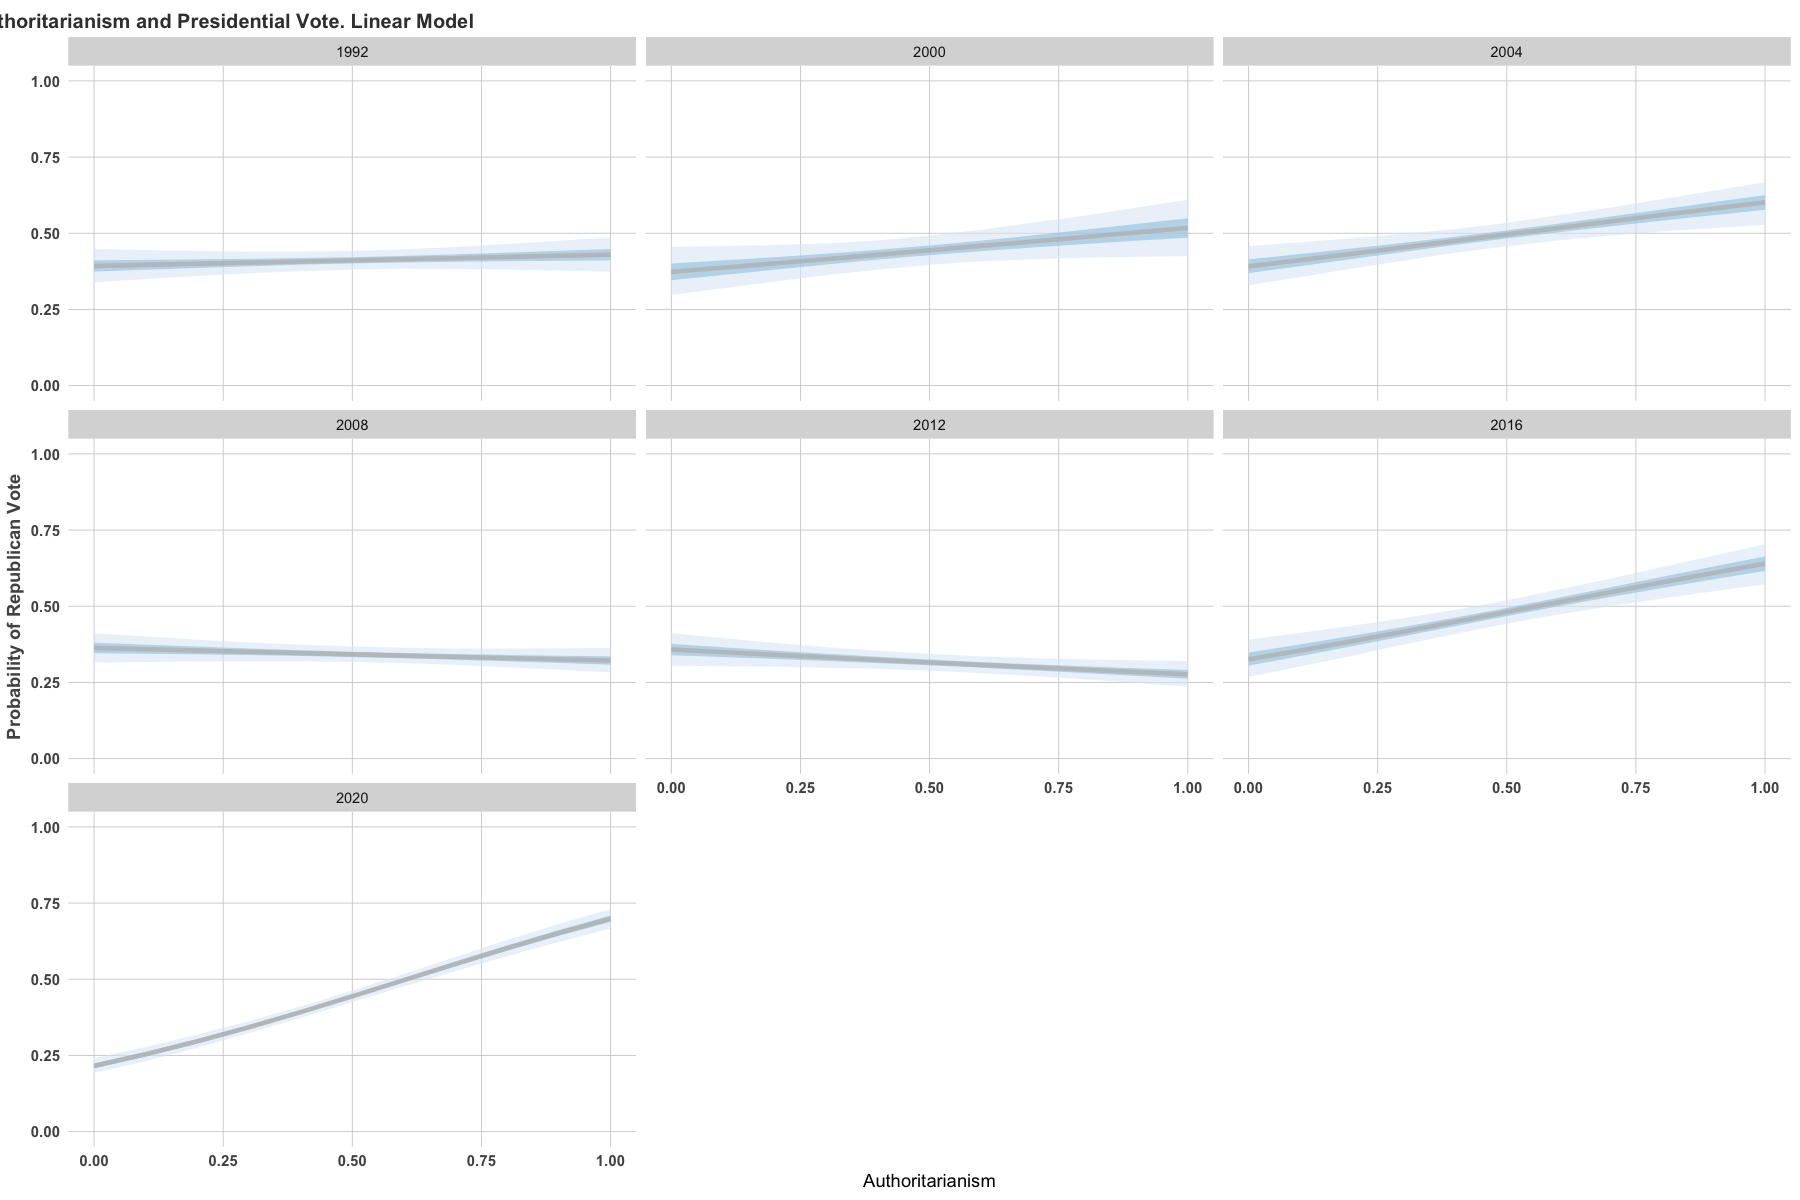

In [78]:
# Generate an expanded dataset varying levels of authoritarianism at fixed covariates.
### linear model (fit0b) ###
expanded_dat = tmp_dat %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11))
model0 = expanded_dat %>%  
          add_linpred_draws(fit0b) %>% 
          mutate(Vote_Republican = plogis(.linpred))  
# Quadratic Model (Fit1)

expanded_dat = tmp_dat %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism^2)
model1 = expanded_dat %>%  
          add_linpred_draws(fit1) %>% 
          mutate(Vote_Republican = plogis(.linpred))   
          
          
options(repr.plot.width=15, repr.plot.height=10)


## Plot linear Effects
 model0 %>%  ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5), color = "grey", alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none")
  


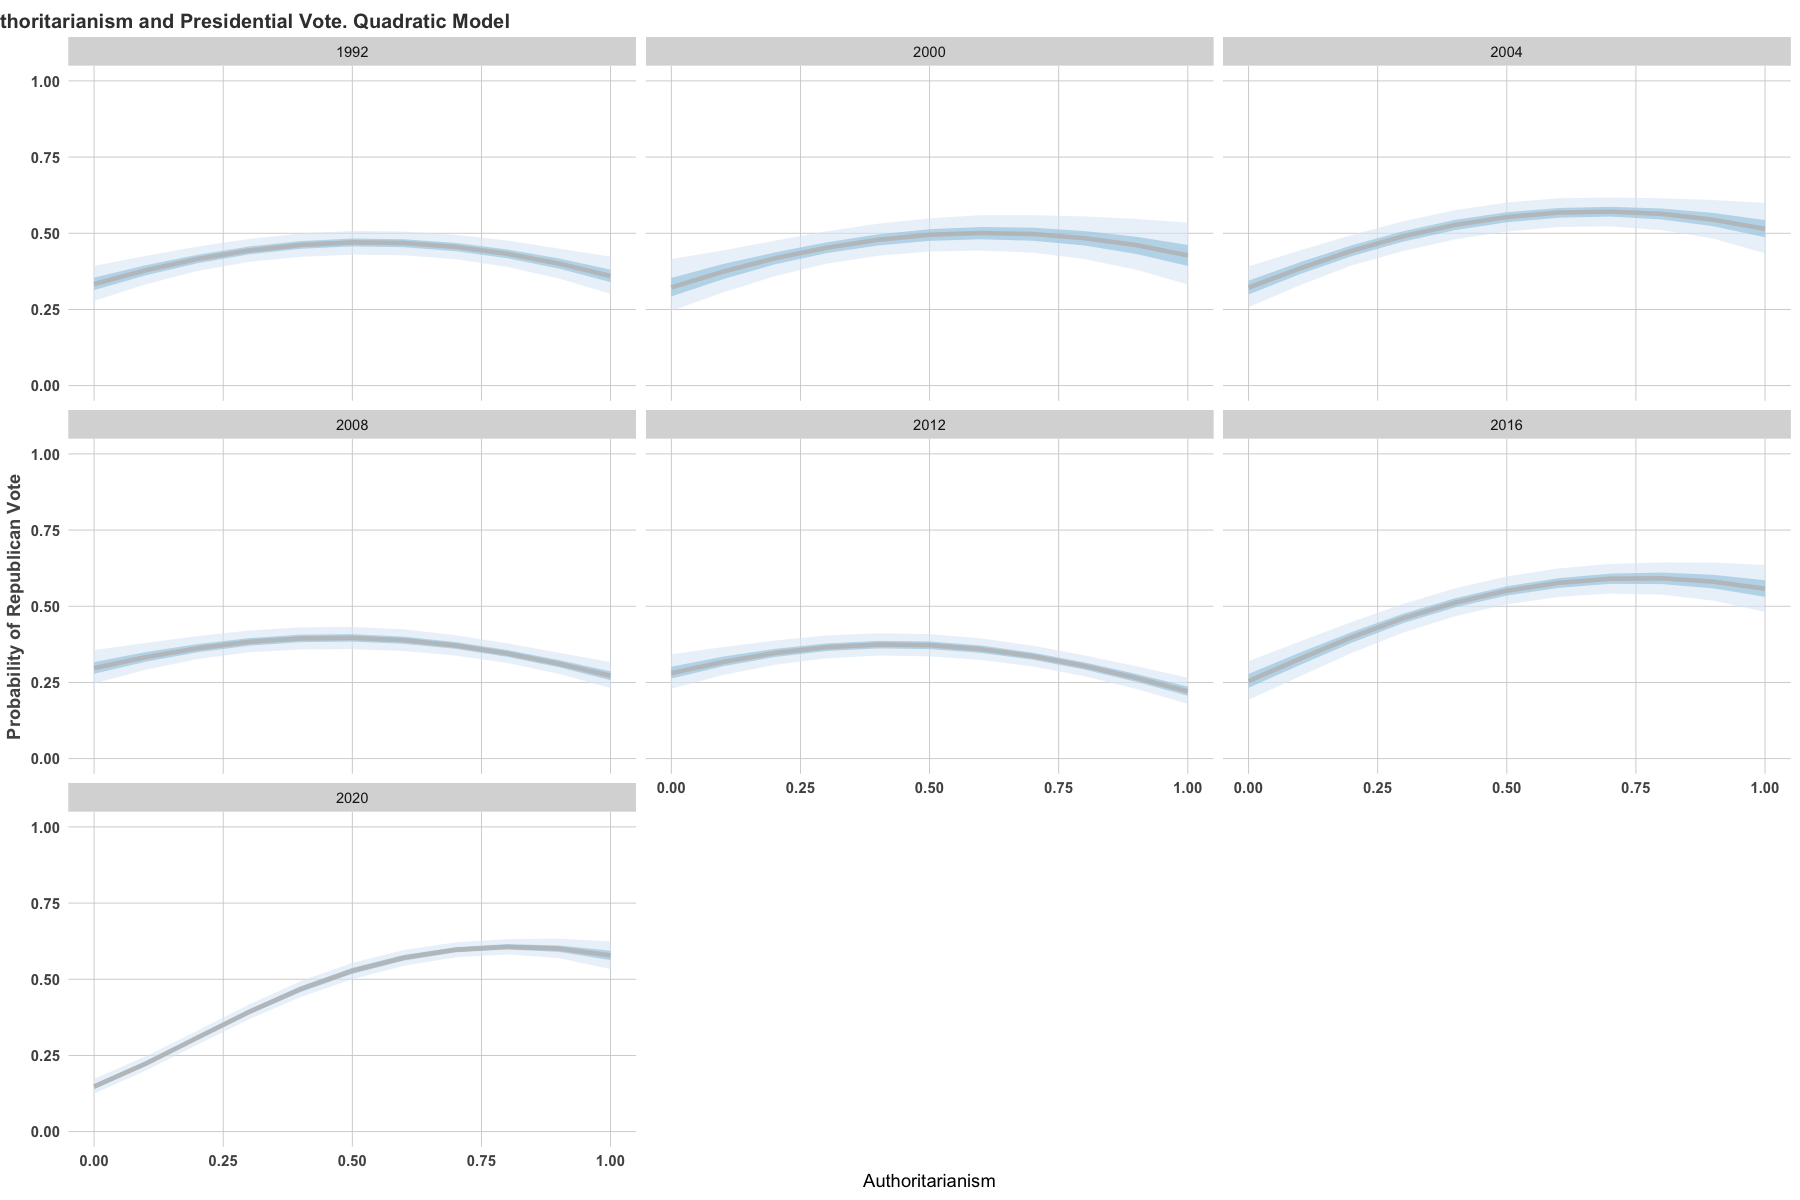

In [77]:
 options(repr.plot.width=15, repr.plot.height=10)
 model1 %>%  ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5), color = "grey", alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Quadratic Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none")
  

# Marginal Effects

Average marginal effects are a bit cumbsersome to calculate, due to the size of the data. Basically, we need to predict a value for each voter, fixing all covariates at their observed values and varying levels of authoritarianism. The data is large, the model is complex, so a "posterior" prediction actually means a distribution of predictions for each respondent. 

In [73]:
library(dplyr)
### Model to estimate AME
expanded_dat_0 = tmp_dat %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      add_linpred_draws(fit0b, draws = 1000)   %>% 
                                                      mutate(low_auth = .linpred) 

expanded_dat_1 = tmp_dat %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      add_linpred_draws(fit0b, draws = 1000)   %>% 
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))
marginals

Adding missing grouping variables: `vote`, `authoritarianism`, `authoritarianism_2`, `female`, `age`, `college`, `income`, `jewish`, `catholic`, `other`, `year`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,-0.054429489,0.03601726,0.12655725
2000,-0.003038761,0.13977519,0.28002816
2004,0.087505748,0.20256057,0.31230302
2008,-0.114872868,-0.03978930,0.03323643
2012,-0.162182669,-0.07978837,-0.00174413
2016,0.188991625,0.30311553,0.40756274
2020,0.380503677,0.47311629,0.52648483


Now let's estimate the same AMEs for the quadratic model, since it sounds like that's the one we prefer.

In [62]:
### Model to estimate AME
expanded_dat_0 = tmp_dat %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>% 
                                                      mutate(low_auth = .linpred) 

expanded_dat_1 = tmp_dat %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>% 
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))


Adding missing grouping variables: `vote`, `authoritarianism`, `authoritarianism_2`, `female`, `age`, `college`, `income`, `jewish`, `catholic`, `other`, `year`, `.row`


In [65]:

marginals

year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,-0.05742123,0.02505241,0.109011424
2000,-0.03575900,0.09985790,0.239168741
2004,0.07778540,0.18683004,0.300162654
2008,-0.09870607,-0.02442004,0.041323097
2012,-0.14172529,-0.05866062,0.009479462
2016,0.17518779,0.29532250,0.405692442
2020,0.29018902,0.43010993,0.503668589


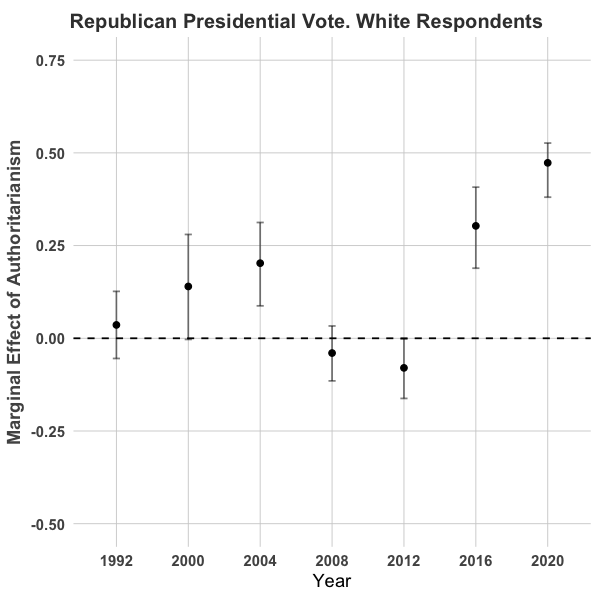

In [76]:
 options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = marginals,
              aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min))+
  geom_point(size=1.5) +
  geom_errorbar(width = 0.10, alpha=0.5) +
  ggtitle("Republican Presidential Vote. White Respondents") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-.5,0.75))+
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") 

# Party Identification and Authoritarianism

It's not difficult to extend this to more complex models. Let's estimate the *authoritarianism* by *education* interaction

In [95]:
library(brms)


Compiling Stan program...

Start sampling

Warning message:
"There were 10 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Warning message:
"Removed 1 rows containing missing values (stat_slabinterval)."
Warning message:
"Removed 1 rows containing missing values (stat_slabinterval)."
Warning message:
"Removed 5 rows containing missing values (stat_slabinterval)."


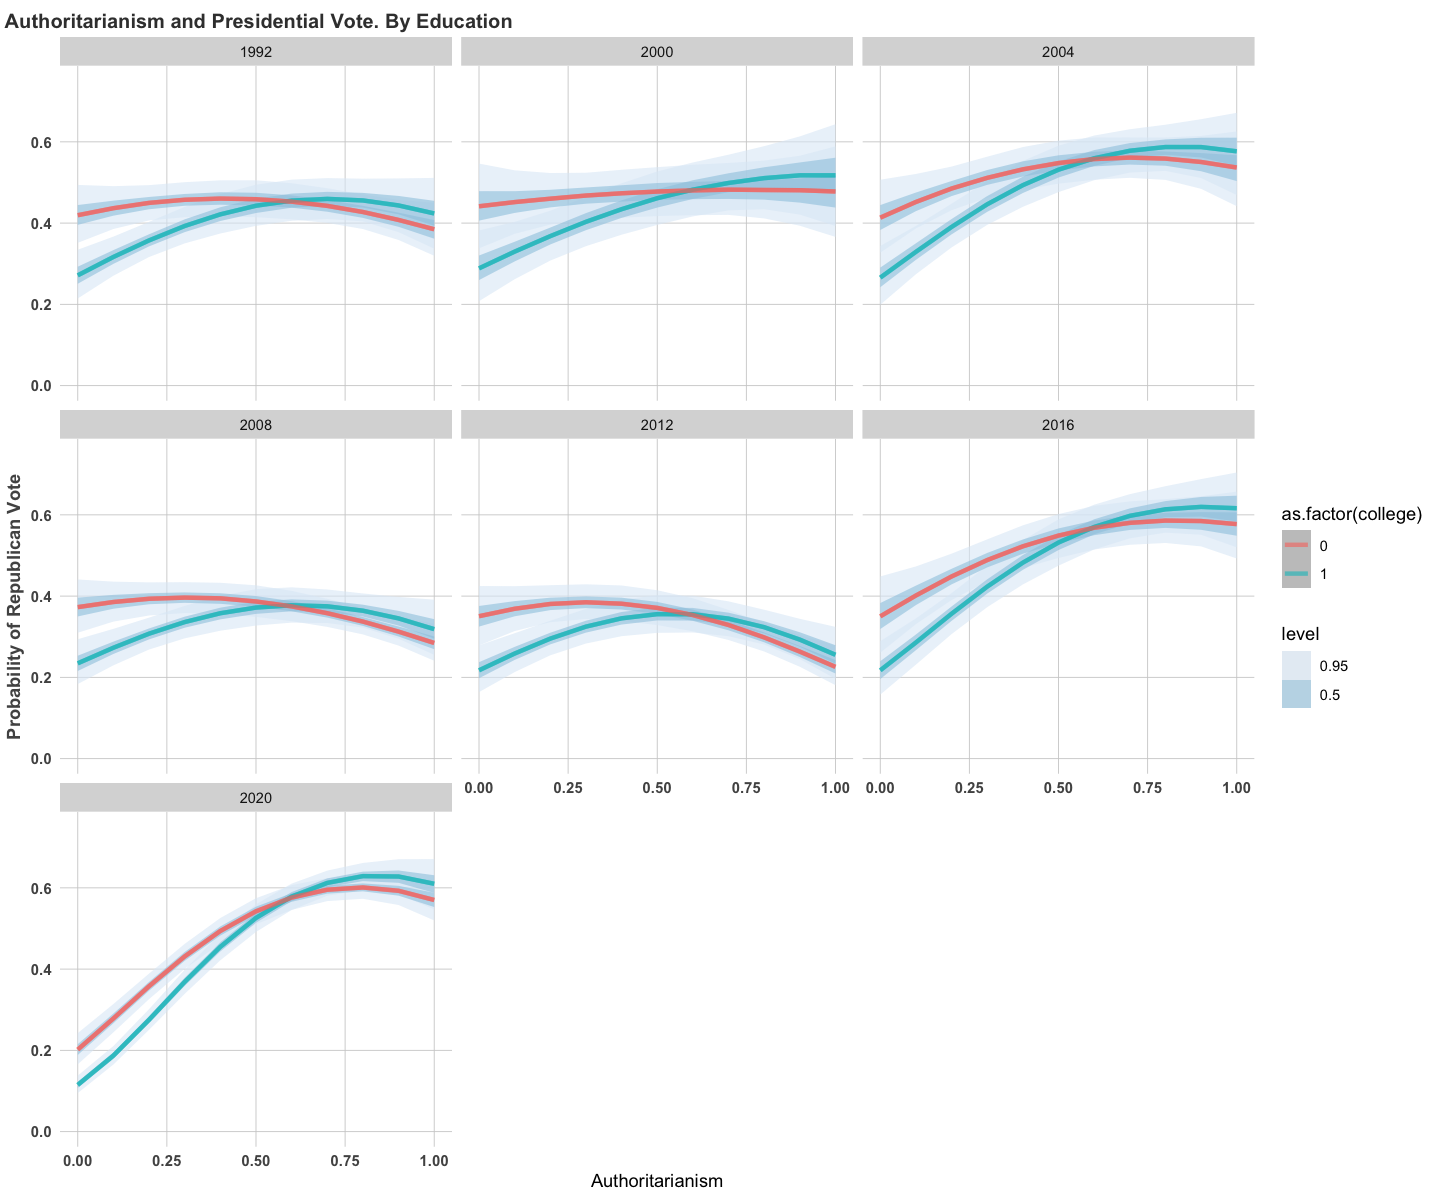

In [109]:
expanded_dat = tmp_dat %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism)
                                                      
model1 = expanded_dat %>%  group_by(year) %>%
          add_linpred_draws(education) %>% 
          mutate(Vote_Republican = plogis(.linpred))   
          
          
options(repr.plot.width=12, repr.plot.height=10)



## Plot linear Effects
 model1 %>%  ggplot(aes(x = authoritarianism, group = college, colour = as.factor(college))) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5),  alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. By Education") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,.75))+
  scale_x_continuous("Authoritarianism") + ggtheme %>% suppressWarnings()
                                                        
                                                      


# Affective Polarization


In [4]:
library(brms)
library(dplyr)
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/user_functions.r")

data$party3      = recode(data$pid*6 + 1, `1` = 1, `2` = 1, `3` = 2 ,`4` = 2, `5` = 2, `6` = 3, `7` = 3) %>% suppressWarnings()
data$republican  = recode(data$pid*6 + 1, `1` = 0, `2` = 0, `3` = 0 ,`4` = 0, `5` = 0, `6` = 1, `7` = 1) %>% suppressWarnings()
data$democrat    = recode(data$pid*6 + 1, `1` = 1, `2` = 1, `3` = 0 ,`4` = 0, `5` = 0, `6` = 0, `7` = 0) %>% suppressWarnings()
data$independent = recode(data$pid*6 + 1, `1` = 0, `2` = 0, `3` = 1 ,`4` = 1, `5` = 1, `6` = 0, `7` = 0) %>% suppressWarnings()
data$feeling.repc = zero.one(data$feeling.repc) %>% as.numeric
data$feeling.demc = zero.one(data$feeling.demc) %>% as.numeric
data$feeling.rep  = zero.one(data$feeling.rep) %>% as.numeric
data$feeling.dem  = zero.one(data$feeling.dem) %>% as.numeric


tmp_dat = data[,c("feeling.repc", "feeling.demc", "feeling.rep", "feeling.dem",
                 "authoritarianism", "authoritarianism_2",
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit()
reps <- brm(feeling.rep~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism|year),
                  data = tmp_dat, 
                  family = "gaussian",
                  chains = 2, cores = options(mc.cores = parallel::detectCores()), seed = 1234, 
                  iter = 1000) 
save(reps, file = "repft.rda")


Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
"There were 12 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess"


In [5]:
repc <- brm(feeling.repc~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism|year),
                  data = tmp_dat, 
                  family = "gaussian",
                  chains = 2, cores = options(mc.cores = parallel::detectCores()), seed = 1234, 
                  iter = 1000) 
save(repc, file = "repcft.rda")

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
"There were 5 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [6]:
dem <- brm(feeling.demc~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism|year),
                  data = tmp_dat, 
                  family = "gaussian",
                  chains = 2, cores = options(mc.cores = parallel::detectCores()), seed = 1234, 
                  iter = 2000) 
save(dem, file = "demcft.rda")

Compiling Stan program...

Start sampling



In [ ]:
dem <- brm(feeling.dem~ female + age + college + income + jewish + 
                  catholic + other + authoritarianism + authoritarianism_2 + 
                  (1+ authoritarianism|year),
                  data = tmp_dat, 
                  family = "gaussian",
                  chains = 2, cores = options(mc.cores = parallel::detectCores()), seed = 1234, 
                  iter = 2000) 
save(demc, file = "demcft.rda")

Compiling Stan program...

Start sampling

Warning message:
"There were 37 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Compiling Stan program...

Start sampling



In [137]:
data$party3  = recode(data$pid*6 + 1, `1` = 1, `2` = 1, `3` = 2 ,`4` = 2, `5` = 2, `6` = 3, `7` = 3) %>% suppressWarnings()
table(data$party3)


   1    2    3 
5096 5117 3549 

In [129]:
data$party3  = recode(data$pid*6 + 1, `1:2` = 1, `3:5` = 2, `6:7`=3) %>% suppressWarnings()

In [35]:
expanded_dat_0 %>% group_by(.row) %>% quantile(marginal, na.rm = T) %>% head()